# Sieci neuronowe i deep learning - Lab 3

# MLP w Tensorflow, cz. II

## Cwiczenie 1

- Zaimportuj zbiór danych korzystając z funkcji tf.keras.datasets.mnist.load_data: https://www.tensorflow.org/api_docs/python/tf/keras/datasets/mnist/load_data
- utwórz obiekty tf.data.Dataset (https://www.tensorflow.org/api_docs/python/tf/data/Dataset), jeden dla zbioru treningowego, drugi dla zbioru testowego, korzystając z metody from_tensor_slices
- użyj funkcji: shuffle do wymiaszania danych, batch do pogrupowania ich w paczki
- korzystając z metody take, pobierz kilka pierwszych danych, przekonwertuj do macierzy numpy i wyświetl

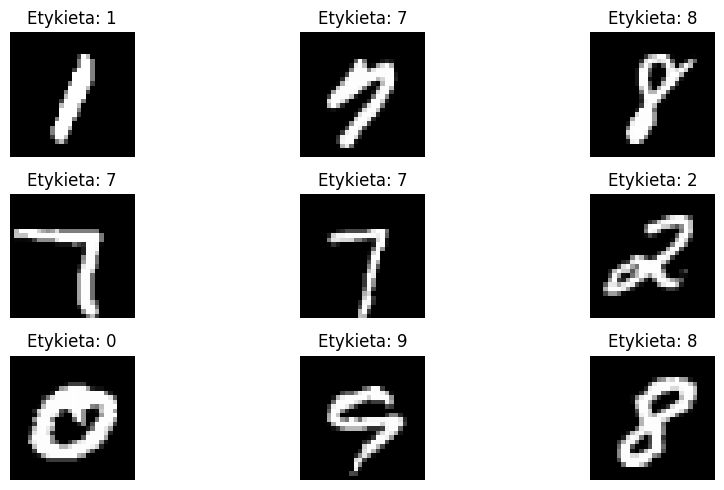

In [2]:
import tensorflow as tf
from tensorflow.keras.datasets.mnist import load_data
import matplotlib.pyplot as plt

# Załadowanie danych MNIST
(x_train, y_train), (x_test, y_test) = load_data()

# Tworzenie obiektów tf.data.Dataset dla zbioru treningowego i testowego
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Shuffle i batchowanie danych
train_ds = train_ds.shuffle(buffer_size=10000).batch(32)
test_ds = test_ds.batch(32)

# Pobranie kilku pierwszych próbek z train_ds i konwersja do macierzy numpy
for images, labels in train_ds.take(1):  # Weźmy tylko pierwszą paczkę danych
    images_np = images.numpy()
    labels_np = labels.numpy()

# Wyświetlenie kilku przykładowych obrazów
plt.figure(figsize=(10, 5))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images_np[i], cmap='gray')
    plt.title(f'Etykieta: {labels_np[i]}')
    plt.axis('off')

plt.tight_layout()
plt.show()


## Ćwiczenie 2

 - Stwórz własną warstwę neuronową, implementując klasę dziedziczącą po tf.keras.layers.Layer (https://www.tensorflow.org/tutorials/customization/custom_layers). Klasa musi zawierać metodę __init__(self, parametry), build(self, input_shape), w której zdefiniujemy parametry przy pomocy metody self.add_weight, oraz metody def call(self, inputs) do zdefiniowania działania warstwy
 - Stwórz model sieci neuronowej, wykorzystujący nowy typ warstwy

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.models import Sequential
import numpy as np

# Definicja niestandardowej warstwy
class CustomLayer(layers.Layer):
    def __init__(self, units=32):
        super(CustomLayer, self).__init__()
        self.units = units

    def build(self, input_shape):
        # Dodajemy wagę i przesunięcie (bias)
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer="random_normal",
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer="zeros",
                                 trainable=True)

    def call(self, inputs):
        # Zastosowanie transformacji liniowej: y = x * W + b
        return tf.matmul(inputs, self.w) + self.b

# Tworzenie modelu sekwencyjnego wykorzystującego niestandardową warstwę
model = Sequential([
    layers.Flatten(input_shape=(28, 28)),  # Rozwijamy obraz 28x28 na wektor
    CustomLayer(64),                       # Nasza niestandardowa warstwa z 64 jednostkami
    layers.Activation('relu'),             # Aktywacja ReLU
    layers.Dense(10, activation='softmax') # Warstwa wyjściowa z 10 klasami
])

# Kompilacja modelu
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

# Wyświetlenie struktury modelu
model.summary()

c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_layer (CustomLayer)      │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,890 (198.79 KB)

 Trainable params: 50,890 (198.79 KB)

 Non-trainable params: 0 (0.00 B)

## Ćwiczenie 3

- Utwórz obiekt odpowiedniej funkcji straty oraz wybranego optymalizatora
- Utwórz obiekty odpowiednich metryk, zarówno dla zbioru treningowego jak i testowego
- Stworz funkcję do trenowania train_step(x,y) z wykorzystaniem obiektu tf.GradientTape, do monitorowania gradientów. Wykorzystaj funkcję "gradient" tego obiektu do wyznaczenia gradientów funkcji straty względem parametrów modelu (model.trainable_variables) oraz metodę "apply_gradients" optymalizatora do modyfikacji tych parametrów. Opatrz funkcję dekoratorem @tf.function
- Utwórz podobną funkcję dla kroku testowania modelu

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Definicja modelu z warstwą Flatten
class SimpleModel(Model):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.flatten = layers.Flatten()  # Dodajemy warstwę Flatten
        self.dense1 = layers.Dense(64, activation='relu')
        self.dense2 = layers.Dense(10, activation='softmax')  # Warstwa wyjściowa dla klasyfikacji

    def call(self, inputs):
        x = self.flatten(inputs)  # Spłaszczenie wejścia
        x = self.dense1(x)
        return self.dense2(x)

# Utwórz obiekt funkcji straty i optymalizatora
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)  # 'from_logits=False' ponieważ używamy softmax
optimizer = tf.keras.optimizers.Adam()

# Utwórz obiekty metryk
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
test_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

# Funkcja do trenowania modelu (jeden krok)
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        # Obliczamy wyjście modelu i stratę
        y_pred = model(x, training=True)
        loss = loss_fn(y, y_pred)

    # Obliczamy gradienty
    gradients = tape.gradient(loss, model.trainable_variables)

    # Aktualizujemy wagi modelu
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Aktualizujemy metrykę dokładności dla treningu
    train_acc_metric.update_state(y, y_pred)

    return loss

# Funkcja do testowania modelu (jeden krok)
@tf.function
def test_step(x, y):
    # Obliczamy wyjście modelu
    y_pred = model(x, training=False)
    loss = loss_fn(y, y_pred)

    # Aktualizujemy metrykę dokładności dla testu
    test_acc_metric.update_state(y, y_pred)

    return loss

# Przykładowe dane
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Przekształcamy dane w kształt [batch_size, 28, 28, 1] (dodajemy wymiar kanału)
x_train = x_train[..., tf.newaxis]  # Dodanie wymiaru kanału
x_test = x_test[..., tf.newaxis]    # Dodanie wymiaru kanału

# Normalizacja danych wejściowych do zakresu [0, 1]
x_train = x_train / 255.0
x_test = x_test / 255.0

# Tworzymy model
model = SimpleModel()

# Tworzymy Dataset dla treningu i testu
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

# Trening - 1 epoka
for epoch in range(1):
    print("Start training")
    for step, (x_batch, y_batch) in enumerate(train_ds):
        loss = train_step(x_batch, y_batch)
        if step % 100 == 0:
            print(f"Step {step}, Loss: {loss.numpy()}, Train Accuracy: {train_acc_metric.result().numpy()}")

    # Wyświetlamy dokładność treningową po epokach
    print(f"End of epoch {epoch}, Training Accuracy: {train_acc_metric.result().numpy()}")

# Testowanie - 1 epoka
for epoch in range(1):
    print("Start testing")
    for step, (x_batch, y_batch) in enumerate(test_ds):
        loss = test_step(x_batch, y_batch)
        if step % 100 == 0:
            print(f"Step {step}, Test Loss: {loss.numpy()}, Test Accuracy: {test_acc_metric.result().numpy()}")

    # Wyświetlamy dokładność testową po epokach
    print(f"End of epoch {epoch}, Test Accuracy: {test_acc_metric.result().numpy()}")


Start training
Step 0, Loss: 2.2612411975860596, Train Accuracy: 0.1875
Step 100, Loss: 0.48317402601242065, Train Accuracy: 0.7336015105247498
Step 200, Loss: 0.16578122973442078, Train Accuracy: 0.8011505007743835
Step 300, Loss: 0.26816582679748535, Train Accuracy: 0.8343023061752319
Step 400, Loss: 0.5244916081428528, Train Accuracy: 0.8527898788452148
Step 500, Loss: 0.28649041056632996, Train Accuracy: 0.8647704720497131
Step 600, Loss: 0.3789319396018982, Train Accuracy: 0.8739080429077148
Step 700, Loss: 0.34990981221199036, Train Accuracy: 0.8802157640457153
Step 800, Loss: 0.19603581726551056, Train Accuracy: 0.8851435780525208
Step 900, Loss: 0.2861492931842804, Train Accuracy: 0.8903648853302002
Step 1000, Loss: 0.09428104758262634, Train Accuracy: 0.8945741653442383
Step 1100, Loss: 0.2261473536491394, Train Accuracy: 0.8979620933532715
Step 1200, Loss: 0.1591455191373825, Train Accuracy: 0.9005516171455383
Step 1300, Loss: 0.5335155725479126, Train Accuracy: 0.90300732851

## Ćwiczenie 4

 - Zaimplementuj główną pętlę uczenia modelu dla zadanej liczby epok. Na starcie każdej epoki zresetuj ustawienia obiektów metryk (metodą reset_state), następnie wykonaj kroki uczenia na batchu ze zbioru treningowego oraz testowania na batchu ze zbioru testowego (wykorzystaj zbiory z ćwiczenia nr 1), oraz wyświetl lub zapisz do listy wyniki funkcji straty i dokładności

In [ ]:
# Parametry
EPOCHS = 5  # Możesz ustawić dowolną liczbę epok

# Listy do przechowywania wyników dla każdej epoki
train_loss_results = []
train_accuracy_results = []
test_loss_results = []
test_accuracy_results = []

# Główna pętla uczenia
for epoch in range(EPOCHS):
    print(f"Epoka {epoch + 1}/{EPOCHS}")

    # Reset metryk na początku każdej epoki
    # train_acc_metric.reset_states()
    # test_acc_metric.reset_states()

    # Pętla uczenia dla zbioru treningowego
    for x_batch_train, y_batch_train in train_ds:
        train_loss = train_step(x_batch_train, y_batch_train)
    
    # Obliczamy dokładność i stratę dla zbioru treningowego na koniec epoki
    train_accuracy = train_acc_metric.result().numpy()
    train_loss_results.append(train_loss.numpy())
    train_accuracy_results.append(train_accuracy)

    # Pętla testowania dla zbioru testowego
    for x_batch_test, y_batch_test in test_ds:
        test_loss = test_step(x_batch_test, y_batch_test)

    # Obliczamy dokładność i stratę dla zbioru testowego na koniec epoki
    test_accuracy = test_acc_metric.result().numpy()
    test_loss_results.append(test_loss.numpy())
    test_accuracy_results.append(test_accuracy)

    # Wyświetlenie wyników na koniec każdej epoki
    print(f"Epoka {epoch + 1}, Trening - Strata: {train_loss.numpy()}, Dokładność: {train_accuracy}")
    print(f"Epoka {epoch + 1}, Testowanie - Strata: {test_loss.numpy()}, Dokładność: {test_accuracy}")

print("Trening zakończony.")


Epoka 1/5


AttributeError: 'SparseCategoricalAccuracy' object has no attribute 'reset_states'

# OPTYMALIZACJA HIPERPARAMETRÓW

## Ćwiczenie 5

- zaimportuj pakiet keras-tuner 
- Utwórz klasę dziedziczącą po klasie kt.HyperModel (https://keras.io/api/keras_tuner/hypermodels/), której metodą jest metoda def build(self, hp), zwracająca model generowany (i skompilowany) z wykorzystaniem frameworku Keras. parametr "hp" pozwala na definiowanie przedziałów poszukiwań parametrów modelu (np. liczby neuronów w warstwie)
- Utwórz obiekt tunera (np. kt.RandomSearch, https://keras.io/api/keras_tuner/tuners/) 
- Naucz model i znajdź optymalne wartości hiperparametrów metodą tuner.search (przyjmuje takie same parametry jak metoda "fit" przy trenowaniu modeli)


In [ ]:
import keras_tuner as kt
from tensorflow.keras import layers, Model, optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Ładowanie i przygotowanie danych MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalizacja
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Klasa HyperModel
class MyHyperModel(kt.HyperModel):
    def build(self, hp):
        model = Model()
        inputs = layers.Input(shape=(28, 28))
        x = layers.Flatten()(inputs)
        
        # Pierwsza warstwa - liczba neuronów poszukiwana między 32 a 512
        x = layers.Dense(
            units=hp.Int('units1', min_value=32, max_value=512, step=32), 
            activation='relu'
        )(x)
        
        # Druga warstwa - liczba neuronów poszukiwana między 32 a 512
        x = layers.Dense(
            units=hp.Int('units2', min_value=32, max_value=512, step=32),
            activation='relu'
        )(x)
        
        # Wyjście
        outputs = layers.Dense(10, activation='softmax')(x)
        model = Model(inputs=inputs, outputs=outputs)
        
        # Kompilacja modelu
        model.compile(
            optimizer=optimizers.Adam(
                hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
            ),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

# Obiekt tunera
tuner = kt.RandomSearch(
    MyHyperModel(),
    objective='val_loss',
    max_trials=5,  # Maksymalna liczba prób poszukiwań
    executions_per_trial=3,  # Liczba wykonanych prób dla każdego zestawu hiperparametrów
    directory='my_dir',  # Katalog do zapisu wyników
    project_name='mnist_tuning'  # Nazwa projektu
)

# Wyszukiwanie optymalnych wartości hiperparametrów
tuner.search(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

# Wyświetlenie najlepszych hiperparametrów
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Najlepsze hiperparametry: Jednostki warstwy 1: {best_hps.get('units1')}, Jednostki warstwy 2: {best_hps.get('units2')}, Learning rate: {best_hps.get('learning_rate')}")
